In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["HUGGINGFACE_API_KEY"]=os.environ["HUGGINGFACE_API_KEY"]

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.tools.retriever import create_retriever_tool
from pydantic import BaseModel,Field
from typing import Annotated,TypedDict,Sequence
from IPython.display import display,Image
from langgraph.graph import StateGraph,END,START,add_messages
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.messages import BaseMessage
import operator
from langchain import PromptTemplate
from langchain_core.messages import HumanMessage

d:\LANGGRAPH\myvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
embedding=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [5]:
llm=ChatGroq(model="gemma2-9b-it")

In [6]:
llm.invoke("what is gen ai")

AIMessage(content="## Gen AI: Generating the Future with Artificial Intelligence\n\nGen AI, short for **Generative Artificial Intelligence**, is a fascinating branch of AI focused on creating new content. \n\n**Think of it like this:** instead of simply analyzing existing data, Gen AI learns the patterns and structures within that data and uses that knowledge to generate entirely new outputs. \n\n**Here's a breakdown:**\n\n**What it does:**\n\n* **Creates text:** Write stories, poems, articles, dialogue, and even code.\n* **Generates images:** Produce realistic photographs, artwork, illustrations, and even 3D models.\n* **Composes music:**\n\nWrite original melodies, harmonies, and entire musical pieces.\n* **Designs:**\n\nCraft new product designs, website layouts, and architectural plans.\n\n**How it works:**\n\nGen AI models, often based on **deep learning**, are trained on massive datasets of existing content. They learn the underlying rules and relationships within that data, allo

In [7]:
llm.invoke("what is gen ai")

AIMessage(content='##  Gen AI: The Creative Powerhouse\n\nGen AI, short for **Generative Artificial Intelligence**, is a type of AI that focuses on **creating new content**. \n\nThink of it like this: instead of simply analyzing existing data, Gen AI learns the patterns and structures within that data and uses that knowledge to **generate something entirely new**.\n\n**What can Gen AI create?**\n\nThe possibilities are vast and constantly expanding:\n\n* **Text:** Stories, poems, articles, code, scripts, dialogue\n* **Images:** Photos, paintings, illustrations, 3D models\n* **Audio:** Music, sound effects, voiceovers\n* **Video:** Short clips, animations\n* **Other:**\n\nSynthetic data, game levels, marketing copy\n\n**How does Gen AI work?**\n\nGen AI models are typically trained on massive datasets of existing content. Through a process called **machine learning**, they learn to identify patterns and relationships within that data. This allows them to generate new content that adhere

In [8]:
from langchain_community.document_loaders import TextLoader
loader=TextLoader('sample.txt')
docs=loader.load()
docs

[Document(metadata={'source': 'sample.txt'}, page_content='The definition of Deep learning is that it is the branch of machine learning that is based on artificial neural network architecture. An artificial neural network or ANN uses layers of interconnected nodes called neurons that work together to process and learn from the input data.\n\nIn a fully connected Deep neural network, there is an input layer and one or more hidden layers connected one after the other. Each neuron receives input from the previous layer neurons or the input layer. The output of one neuron becomes the input to other neurons in the next layer of the network, and this process continues until the final layer produces the output of the network. The layers of the neural network transform the input data through a series of nonlinear transformations, allowing the network to learn complex representations of the input data.\n\nDeep Learning - Geeksforgeeks\nScope of Deep Learning\n\nToday Deep learning AI has become

In [9]:
document=RecursiveCharacterTextSplitter(chunk_size=1500,chunk_overlap=50).split_documents(docs)
document

[Document(metadata={'source': 'sample.txt'}, page_content='The definition of Deep learning is that it is the branch of machine learning that is based on artificial neural network architecture. An artificial neural network or ANN uses layers of interconnected nodes called neurons that work together to process and learn from the input data.\n\nIn a fully connected Deep neural network, there is an input layer and one or more hidden layers connected one after the other. Each neuron receives input from the previous layer neurons or the input layer. The output of one neuron becomes the input to other neurons in the next layer of the network, and this process continues until the final layer produces the output of the network. The layers of the neural network transform the input data through a series of nonlinear transformations, allowing the network to learn complex representations of the input data.\n\nDeep Learning - Geeksforgeeks\nScope of Deep Learning\n\nToday Deep learning AI has become

In [10]:
vectordb=FAISS.from_documents(document,embedding)

In [11]:
db=vectordb.as_retriever()

In [12]:
retriever=create_retriever_tool(db,"database retriever","retrieving data from the document")

In [13]:
retriever.name

'database retriever'

In [14]:
tools=[retriever]

In [15]:
tools[0].invoke("what is deep learning")

'The definition of Deep learning is that it is the branch of machine learning that is based on artificial neural network architecture. An artificial neural network or ANN uses layers of interconnected nodes called neurons that work together to process and learn from the input data.\n\nIn a fully connected Deep neural network, there is an input layer and one or more hidden layers connected one after the other. Each neuron receives input from the previous layer neurons or the input layer. The output of one neuron becomes the input to other neurons in the next layer of the network, and this process continues until the final layer produces the output of the network. The layers of the neural network transform the input data through a series of nonlinear transformations, allowing the network to learn complex representations of the input data.\n\nDeep Learning - Geeksforgeeks\nScope of Deep Learning\n\nToday Deep learning AI has become one of the most popular and visible areas of machine lear

In [16]:
tool_node=ToolNode(tools=tools)

In [17]:
with_bind_tools=llm.bind_tools(tools=tools)

messages have the type "list".

The add_messages function appends messages to the list, rather than overwriting them

In [18]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],add_messages]

In [19]:
class Check(BaseModel):
    binary_score:str=Field(description="check the document whether it is relevant to question and give binary score 'yes' or 'no'")

In [20]:
def ai_assisstance(state:AgentState):

    print("==> enter into the ai_assisstance <==")
    question=state["messages"]
    print(question)
    response=with_bind_tools.invoke(question)
    return {"messages":[response]}

In [21]:
def grade_decider(state:AgentState):

    print("==> GRADE DECIDE <==")
    
    with_structured=llm.with_structured_output(Check)

    template="""
           As you are an query checker check whether the given dcoument is related tothe given question.
           here is the document: {document}
           here is the question : {question}
           and finally give the  binary score 'yes'  only if the document is relevant to the question
           otherwise you answer will be 'no'   
    """

    prompt=PromptTemplate(input_variables=['document','question'],
                          template=template)
    
    messages=state["messages"]
    #print("messages",messages)

    question=messages[0].content

    #print("the question",question)

    last_message=messages[-1].content

    docs=last_message

    #print("the last message is",docs)

    chain=prompt|with_structured
    score_result=chain.invoke({"document":docs,"question":question})
    score=score_result.binary_score

    print(f"score is {score}")

    if score=='yes':
        print("RELEVANT DOCUMNET")
        return "generator"
    else:
        return "rewrite query"

In [22]:
def generate(state:AgentState):

    print("==> GENERATING ANSWER< ===")
    messages=state["messages"]

    question=messages[0].content

    print("the question",question)
    last_message=messages[-1].content

    docs=last_message
    print("documnets are",docs)
    template="""
        As you an AI expert answer the following question based on the given content:{context}

        {question}
    """

    prompt=PromptTemplate(input_variables=['context','question'],template=template)

    chain=prompt|llm

    response=chain.invoke({"context":docs,"question":question})
    return {"messages":[response]}


In [23]:
def rewrite(state:AgentState):
    
    print("==>question rewritting<==")

    messages=state["messages"]
    question=messages[0].content

    print(f" question are rewritting {question}")

    message=[HumanMessage(content=f"""
        as you are an question rewritter read the question clearly and rewrite the better way
        here is the question: {question}
        formulate into improved question
    """)]

    better_question=llm.invoke(message)
    return {"messages":better_question}


In [24]:
graph=StateGraph(AgentState)

In [25]:
graph.add_node("agent",ai_assisstance)
graph.add_node("tools",tool_node)
graph.add_node("generating",generate)
graph.add_node("rewritting",rewrite)

In [26]:
graph.add_conditional_edges("agent",tools_condition,
                            {
                                "tools":"tools",
                                END:END
                            })

In [27]:
graph.add_conditional_edges("tools",
                            grade_decider,
                            {
                                "generator":"generating",
                                "rewrite query":"rewritting"
                                
                            })

In [28]:
graph.add_edge(START,"agent")
graph.add_edge("generating",END)

In [29]:
graph.add_edge("rewritting","agent")

In [30]:
app=graph.compile()

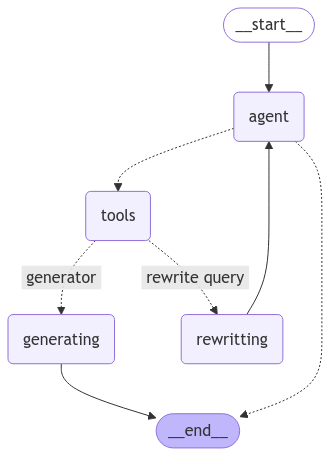

In [31]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [32]:
app.invoke({"messages":["who is president of india"]})

==> enter into the ai_assisstance <==
[HumanMessage(content='who is president of india', additional_kwargs={}, response_metadata={}, id='2b2f052b-ed63-47ea-abdf-5cf1132e4640')]
==> GRADE DECIDE <==
score is no
==>question rewritting<==
 question are rewritting who is president of india
==> enter into the ai_assisstance <==
[HumanMessage(content='who is president of india', additional_kwargs={}, response_metadata={}, id='2b2f052b-ed63-47ea-abdf-5cf1132e4640'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_q1ty', 'function': {'arguments': '{"query":"who is the president of india"}', 'name': 'database retriever'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 956, 'total_tokens': 1041, 'completion_time': 0.154545455, 'prompt_time': 0.030845967, 'queue_time': 0.023949348, 'total_time': 0.185391422}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None

{'messages': [HumanMessage(content='who is president of india', additional_kwargs={}, response_metadata={}, id='2b2f052b-ed63-47ea-abdf-5cf1132e4640'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_q1ty', 'function': {'arguments': '{"query":"who is the president of india"}', 'name': 'database retriever'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 956, 'total_tokens': 1041, 'completion_time': 0.154545455, 'prompt_time': 0.030845967, 'queue_time': 0.023949348, 'total_time': 0.185391422}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-114b81b0-6b3a-407d-bd73-bd8a1b1ebb70-0', tool_calls=[{'name': 'database retriever', 'args': {'query': 'who is the president of india'}, 'id': 'call_q1ty', 'type': 'tool_call'}], usage_metadata={'input_tokens': 956, 'output_tokens': 85, 'total_tokens': 1041}),
  ToolMessage(content='Automatic Text G